## Multidimensional scaling

This could be it.

Steps:

- Take a subset of 1k words? See how much time it costs
- Take the sklearn cdist (cosine)
- Scale that into like 10-D
- See how well it does on some test word pairs

Yeah, no.
Computationally expensive, and not much better than PCA?

In [36]:
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.manifold import MDS
import umap
import math
import dataclasses
import pickle
import random
import numpy as np
import os
import time
import multiprocessing
from joblib import Parallel, delayed
import re
from functools import lru_cache
from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize, StandardScaler
from gensim import models

from matplotlib import pyplot as plt
from typing import *

In [2]:
def read_goog_file(size=None):
    vec_file = '/mnt/Spookley/datasets/semantle/GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    good_word = re.compile(r'^[a-z]+$')
    for w in words:
        # filter out proper nouns, pictograms, emoji, multi-words, etc. Eliminates 95% of the dataset.   
        if not good_word.match(w):
            continue
        
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    w_list = list(w_vecs.keys())
    return w_list, normalize(mat_full, axis=1)

w_list, mat_full_normed = read_goog_file(size=None)
mat_full_normed.shape

(155060, 300)

In [69]:
SUBSET=5000
minimat = mat_full_normed[:SUBSET, :]
dist_mat = cdist(minimat, minimat, metric='cosine')
dist_mat.shape

(5000, 5000)

5000 computed in 67.975


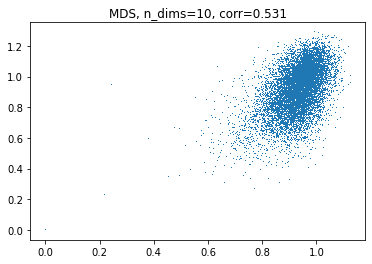

5000 computed in 68.547


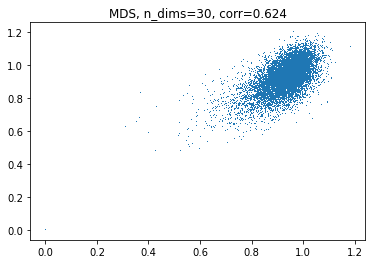

5000 computed in 70.291


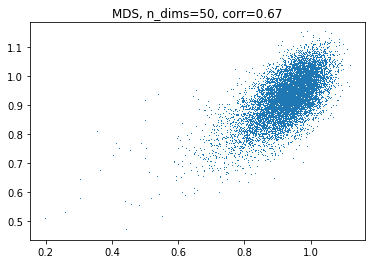

5000 computed in 72.047


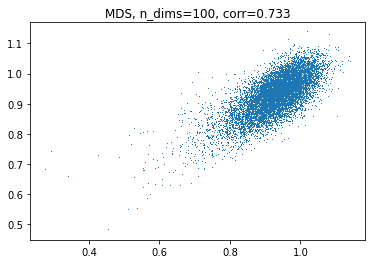

5000 computed in 83.552


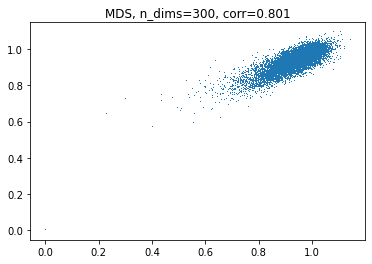

In [75]:

# Times:
# oh wait you're burning CPU elsewhere, wait that out first.
# 1000, 5dims - 7 secs
# 2000, 5dims - 35 secs
# 3000, 5dims - 96 secs
# 4000, 5dims - 180 secs

for ndims in [10, 30, 50, 100, 300]:
    mds = MDS(n_components=ndims, dissimilarity='precomputed', n_init=1)
    t0 = time.time()
    smol_mat = mds.fit_transform(dist_mat)
    t1 = time.time()
    print(len(dist_mat), 'computed in', round(t1-t0, 3))
    smol_dist = squareform(pdist(smol_mat)).reshape(-1)
    orig_dist = dist_mat[:SUBSET, :].reshape(-1)
    cc = np.corrcoef(smol_dist, orig_dist)[0,1]
    
    # too many points makes for a big blob of a plot. To visualize
    # density we need way fewer points.
    s = random.sample(list(range(len(smol_dist))), 10000)
    plt.plot(orig_dist[s], smol_dist[s], ',')
    plt.title('MDS, n_dims={}, corr={}'.format(ndims, round(cc,3)))
    plt.show()